# NY Housing prices and amenities Analysis

*######

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from scipy.stats import linregress
import scipy.stats as st
from pprint import pprint

# Import the FRED economic data API key
from api_keys import api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy



## Fred St.Louis API data extraction of per capita by state

In [2]:
url = f"https://api.stlouisfed.org/geofred/regional/data?api_key={api_key}&series_group=882&date=2022-01-01&region_type=state&units=Dollars&frequency=a&season=NSA&file_type=json"

# Make and API request using the params dictionaty
per_cap_api_req = requests.get(url)
    
# Convert the API response to JSON format
ny_per_cap = per_cap_api_req.json()
#print(json.dumps(ny_per_cap, indent=4, sort_keys=True))
ny_per_cap   

 

{'meta': {'title': '2022 Per Capita Personal Income by State (Dollars)',
  'region': 'state',
  'seasonality': 'Not Seasonally Adjusted',
  'units': 'Dollars',
  'frequency': 'Annual',
  'data': {'2022-01-01': [{'region': 'Louisiana',
     'code': '22',
     'value': 54622,
     'series_id': 'LAPCPI'},
    {'region': 'Nevada', 'code': '32', 'value': 61282, 'series_id': 'NVPCPI'},
    {'region': 'Maryland',
     'code': '24',
     'value': 70730,
     'series_id': 'MDPCPI'},
    {'region': 'Arizona', 'code': '04', 'value': 56667, 'series_id': 'AZPCPI'},
    {'region': 'New York',
     'code': '36',
     'value': 78089,
     'series_id': 'NYPCPI'},
    {'region': 'Massachusetts',
     'code': '25',
     'value': 84945,
     'series_id': 'MAPCPI'},
    {'region': 'Ohio', 'code': '39', 'value': 57880, 'series_id': 'OHPCPI'},
    {'region': 'Kentucky',
     'code': '21',
     'value': 52109,
     'series_id': 'KYPCPI'},
    {'region': 'Oklahoma',
     'code': '40',
     'value': 54998,
    

In [3]:
# Print a few keys from the response JSON.
print(f"API Title  {ny_per_cap['meta']['title']}.")
print(f"Per Capita state  {ny_per_cap['meta']['data']}.")


API Title  2022 Per Capita Personal Income by State (Dollars).
Per Capita state  {'2022-01-01': [{'region': 'Louisiana', 'code': '22', 'value': 54622, 'series_id': 'LAPCPI'}, {'region': 'Nevada', 'code': '32', 'value': 61282, 'series_id': 'NVPCPI'}, {'region': 'Maryland', 'code': '24', 'value': 70730, 'series_id': 'MDPCPI'}, {'region': 'Arizona', 'code': '04', 'value': 56667, 'series_id': 'AZPCPI'}, {'region': 'New York', 'code': '36', 'value': 78089, 'series_id': 'NYPCPI'}, {'region': 'Massachusetts', 'code': '25', 'value': 84945, 'series_id': 'MAPCPI'}, {'region': 'Ohio', 'code': '39', 'value': 57880, 'series_id': 'OHPCPI'}, {'region': 'Kentucky', 'code': '21', 'value': 52109, 'series_id': 'KYPCPI'}, {'region': 'Oklahoma', 'code': '40', 'value': 54998, 'series_id': 'OKPCPI'}, {'region': 'Kansas', 'code': '20', 'value': 60152, 'series_id': 'KSPCPI'}, {'region': 'Oregon', 'code': '41', 'value': 62767, 'series_id': 'ORPCPI'}, {'region': 'Indiana', 'code': '18', 'value': 57930, 'series_i

In [4]:
print(f"Per Capita state  {ny_per_cap['meta']['data']['2022-01-01'][4]['region']}.")
print(f"Per Capita income  {ny_per_cap['meta']['data']['2022-01-01'][4]['value']}.")
print(f"Per Capita state code  {ny_per_cap['meta']['data']['2022-01-01'][4]['series_id']}.")

Per Capita state  New York.
Per Capita income  78089.
Per Capita state code  NYPCPI.


### New York's percapita income is $78K however the prices of homes are in millions.  It is way out of league for median household. However, there are condos that are much more affordable

## NY Housing Summary

In [5]:
# File to Load (Remember to Change These)
ny_condo_zip = Path("Resources/Zip_Condo_NY.csv")

In [6]:
# Read NY Condo File and store into Pandas DataFrames
ny_condo_df = pd.read_csv(ny_condo_zip)
ny_condo_df.head()


,RegionID,SizeRank,ZIP,StateName,City,CountyName,1/31/2000,2/29/2000,3/31/2000,4/30/2000,...,6/30/2022,7/31/2022,8/31/2022,9/30/2022,10/31/2022,11/30/2022,12/31/2022,1/31/2023,2/28/2023,3/31/2023
0,62080,3,11368,NY,New York,Queens County,72326.24806,73058.07600,73605.93937,74520.27326,...,323320.4228,323582.1276,322854.9354,321141.2196,319297.2403,318652.8798,317396.4402,317356.3637,317934.0560,320049.8439
1,62093,5,11385,NY,New York,Queens County,237110.43860,238131.95040,239424.02450,241243.86140,...,756565.6813,761907.7575,763175.7401,760084.2780,757418.3347,755532.4503,752020.1612,748779.4051,744667.2061,743864.4351
2,62019,7,11208,NY,New York,Kings County,163989.25800,164208.08090,164484.18200,165244.97820,...,620286.4212,623775.5077,624703.3500,622540.9366,620430.5181,618409.3749,615754.8843,615610.2492,614976.3908,615973.2322
3,62085,14,11373,NY,New York,Queens County,103596.04000,104117.75140,104691.48340,105735.75390,...,394118.9901,393604.3312,390406.7664,384857.8398,380023.8605,376733.3430,373091.9836,369140.8831,367308.2085,368761.4198
4,61807,15,10467,NY,New York,Bronx County,53110.13909,53388.71286,53648.62726,54313.14293,...,275828.2021,274285.9300,269677.7380,262307.8542,257158.9879,254763.1812,253742.7570,249699.7851,244591.3299,239929.5746


In [7]:
# remove blank rows from the dataframe
ny_condo_cln_df = ny_condo_df.dropna()
ny_condo_cln_df

,RegionID,SizeRank,ZIP,StateName,City,CountyName,1/31/2000,2/29/2000,3/31/2000,4/30/2000,...,6/30/2022,7/31/2022,8/31/2022,9/30/2022,10/31/2022,11/30/2022,12/31/2022,1/31/2023,2/28/2023,3/31/2023
0,62080,3,11368,NY,New York,Queens County,72326.24806,73058.07600,73605.93937,74520.27326,...,323320.4228,323582.1276,322854.9354,321141.2196,319297.2403,318652.8798,317396.4402,317356.3637,317934.0560,320049.8439
1,62093,5,11385,NY,New York,Queens County,237110.43860,238131.95040,239424.02450,241243.86140,...,756565.6813,761907.7575,763175.7401,760084.2780,757418.3347,755532.4503,752020.1612,748779.4051,744667.2061,743864.4351
2,62019,7,11208,NY,New York,Kings County,163989.25800,164208.08090,164484.18200,165244.97820,...,620286.4212,623775.5077,624703.3500,622540.9366,620430.5181,618409.3749,615754.8843,615610.2492,614976.3908,615973.2322
4,61807,15,10467,NY,New York,Bronx County,53110.13909,53388.71286,53648.62726,54313.14293,...,275828.2021,274285.9300,269677.7380,262307.8542,257158.9879,254763.1812,253742.7570,249699.7851,244591.3299,239929.5746
7,62018,18,11207,NY,New York,Kings County,131378.69130,131781.85800,132208.76490,133321.97660,...,524732.5270,527120.1603,528705.6416,528416.2207,528189.2970,527269.7806,525269.9112,525235.4648,524194.3649,523839.0165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,62754,39809,12791,NY,Youngsville,Sullivan County,85632.05117,85826.87243,86043.51632,86828.96563,...,230137.4465,233624.1340,235809.3415,236531.0437,237503.9949,238839.6129,238998.1736,239188.4796,239837.9204,242138.4109
1563,63622,39809,14592,NY,York,Livingston County,97830.94409,97729.44044,97809.39539,97767.23001,...,175040.4809,176684.1997,177111.5298,176416.3182,175939.0787,175757.8694,175921.9205,176154.9945,176752.1153,178124.5799
1564,62755,39809,12792,NY,Yulan,Sullivan County,78900.94276,79471.83881,80037.25833,80681.95042,...,278768.5483,280952.3081,280620.7505,279565.5154,278685.9486,278098.2666,276954.6540,275509.3668,273871.0362,272556.2253
1565,63437,39809,14134,NY,Chaffee,Erie County,55247.91304,56253.58484,57854.76129,60360.11325,...,199791.2306,201780.0219,201919.1765,200571.1374,199292.4204,198708.2667,197977.1977,198072.7942,199659.9207,202604.8971


In [8]:
# create a new dataframe with neede columns
ny_condo_cln_df = ny_condo_cln_df[['RegionID','SizeRank','ZIP','StateName','City','CountyName','3/31/2022','3/31/2023']].copy()

ny_condo_cln_df

,RegionID,SizeRank,ZIP,StateName,City,CountyName,3/31/2022,3/31/2023
0,62080,3,11368,NY,New York,Queens County,322113.6386,320049.8439
1,62093,5,11385,NY,New York,Queens County,739626.8581,743864.4351
2,62019,7,11208,NY,New York,Kings County,609047.2303,615973.2322
4,61807,15,10467,NY,New York,Bronx County,258710.1760,239929.5746
7,62018,18,11207,NY,New York,Kings County,518031.4312,523839.0165
...,...,...,...,...,...,...,...,...
1560,62754,39809,12791,NY,Youngsville,Sullivan County,212629.2458,242138.4109
1563,63622,39809,14592,NY,York,Livingston County,168398.7431,178124.5799
1564,62755,39809,12792,NY,Yulan,Sullivan County,258810.6806,272556.2253
1565,63437,39809,14134,NY,Chaffee,Erie County,189990.4608,202604.8971


0       307405.338503
1       716636.926970
2       593146.322351
4       230041.921209
7       504182.345588
            ...      
1560    232174.753836
1563    170363.569681
1564    261545.924067
1565    194001.545584
1566    193702.359505
Name: 3/31/2023, Length: 1264, dtype: float64
0.9655910791287202 -1631.9356437779497 0.9982150949820591 0.0 0.001626178097124127
Year over Year correlation coefficient for NY condos is 1.0


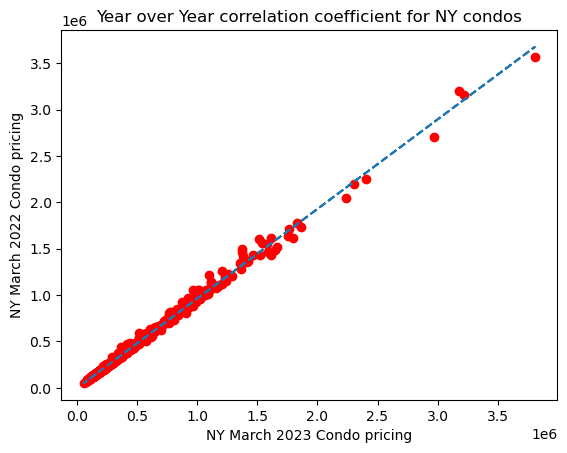

In [9]:
# Calculate the correlation coefficient and linear regression model 
y_axis_val = ny_condo_cln_df["3/31/2022"]
x_axis_val = ny_condo_cln_df["3/31/2023"]

d_slope, d_intercept, d_rvalu, d_pvalue, d_std_err = st.linregress( x_axis_val, y_axis_val)

d_fit = (d_slope * x_axis_val )+ d_intercept
print(d_fit)
print(d_slope,d_intercept, d_rvalu,d_pvalue, d_std_err )
print(f"Year over Year correlation coefficient for NY condos is {round(st.pearsonr(x_axis_val,y_axis_val)[0],2)}")

plt.scatter(x_axis_val,y_axis_val, color="red")

plt.plot(x_axis_val,d_fit,"--")

plt.title('Year over Year correlation coefficient for NY condos')
plt.ylabel('NY March 2022 Condo pricing')
plt.xlabel('NY March 2023 Condo pricing')

plt.show()

#### the year over year price of condoes in NY is perfectly correlated.  Making us to belive the price in 2022 and 2023 did not vary much